In [112]:
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from tqdm import tqdm

In [104]:
import warnings
warnings.filterwarnings('ignore')

#### Таблица с исходными и исправленными запросами

- orig - исходный запрос
- new - исправленный запрос
- deleted - удаленные из исходного запроса слова
- added - добавленные в исходный запрос слова

In [150]:
queries_df = pd.read_csv('queries_fixed.csv', usecols=['нулевой запрос', 'успешный запрос', 'что выкинули', 'что добавили'])
queries_df.columns = ['old', 'new', 'deleted', 'added']
queries_df = queries_df[(queries_df['old'] == queries_df['old']) & (queries_df['new'] == queries_df['new'])]
print(queries_df.shape)
queries_df['old'] = queries_df['old'].apply(lambda sent: sent.strip())
queries_df['new'] = queries_df['new'].apply(lambda sent: sent.strip())
queries_df.tail()

(4410, 4)


,old,new,deleted,added
4412,является ли нарушением законодательства несоот...,является ли нарушением законодательства несоот...,его на и выполнение создания в пл отраженными,NaN
4413,является ли несовместное проживание с детьми п...,имеет ли право требовать пенсионный фонд при н...,отказа детьми поводом с в проживание является ...,назначении фонд имеет совместном право прожива...
4414,является ли объектами налогообложения налогом ...,пожарная сигнализация налог на имущество в 2019,и объектами видеонаблюдения ли система являетс...,налог
4415,является ли основанием для увольнения руководи...,типовая форма договора с руководителем федерал...,указанием увольнения задолженности ли автономн...,форма руководителем договора типовая
4416,#ERROR!,- ткань должна соответствовать требованиям ГОС...,NaN,ГОСТ 29298-2005 Ткани хлопчатобумажные и смеша...


#### Таблицы с нормальными формами для исходных и исправленных запросов

- query - текст запроса
- normal - все варианты нормализованного запроса (через ;)
- syn - однословные синонимы всех слов запроса

In [151]:
normforms_old_df = pd.read_table('queries_norm.txt', names=('query', 'normal', 'syn'),
                                 sep=':', encoding='mbcs').dropna()
print(normforms_old_df.shape)
normforms_old_df['query']  = normforms_old_df['query'].apply( lambda sent: sent.strip())
normforms_old_df['normal'] = normforms_old_df['normal'].apply(lambda sent: sent.strip())
normforms_old_df = normforms_old_df[normforms_old_df['query'] == normforms_old_df['query']]
normforms_old_df.tail()

(4401, 3)


,query,normal,syn
4411,явление о признании неуважительными причин не ...,ЯВЛЕНИЕ ПРИЗНАВАТЬ НЕУВАЖЕНИЕ ПРИЧИНА НЕ~ПРОЖИ...,6 6Н БОЛЕЕ ВМЕСТЕ ВОСПИТАНИЕ ВЫШЕ ДЕТСКИЙ МЕС...
4412,является ли нарушением законодательства несоот...,НАРУШЕНИЕ ЗАКОНОДАТЕЛЬСТВО НЕ~СООТВЕТСТВИЕ ФАК...,БЮДЖЕТНИК БЮДЖЕТНО ВКЛЮЧАТЬ ВЫПОЛНЕНИЕ ГОССЕК...
4413,является ли несовместное проживание с детьми п...,НЕСОВМЕСТНЫЙ ПРОЖИВАНИЕ ДЕТСКИЙ ПОВОД ОТКАЗ ПЕ...,ДЕТСКИЙ НЕСОВЕРШЕННОЛЕТИЕ НЕСОВЕРШЕННОЛЕТНИЙ ...
4414,является ли объектами налогообложения налогом ...,ОБЪЕКТ НАЛОГООБЛОЖЕНИЕ НАЛОГ ИМУЩЕСТВЕННЫЙ ПОЖ...,2019 2019Г ВИДЕО ИМУЩЕСТВЕННЫЙ НАЛОГ НАЛОГООБ...
4415,является ли основанием для увольнения руководи...,ОСНОВАНИЕ ПРЕКРАЩЕНИЕ ТРУДОВОЙ ДОГОВОР РУКОВОД...,АВТОНОМНЫЙ БЮДЖЕТНИК БЮДЖЕТНО ВЕЛИЧИНА ВОВРЕМ...


In [131]:
normforms_new_df = pd.read_table('new_queries_norm.txt', names=('query', 'normal', 'syn'),
                                 sep=':', encoding='mbcs').dropna()
print(normforms_new_df.shape)
normforms_new_df['query']  = normforms_new_df['query'].apply( lambda sent: sent.strip())
normforms_new_df['normal'] = normforms_new_df['normal'].apply(lambda sent: sent.strip())
normforms_new_df.tail()

(4409, 3)


,query,normal,syn
4405,является ли нарушением законодательства несоот...,НАРУШЕНИЕ ЗАКОНОДАТЕЛЬСТВО НЕ~СООТВЕТСТВИЕ ФАК...,БЮДЖЕТНИК БЮДЖЕТНО ГОССЕКТОР ГОСУДАРСТВЕННО З...
4406,имеет ли право требовать пенсионный фонд при н...,ПРАВО ТРЕБОВАТЬ ПЕНСИОННЫЙ-ФОНД НАЗНАЧЕНИЕ ПЕН...,ВМЕСТЕ ВПРАВЕ ЗАТРЕБОВАНИЕ ЗАТРЕБОВАТЬ НАЗНАЧ...
4407,пожарная сигнализация налог на имущество в 2019,ПОЖАРНО СИГНАЛИЗАЦИЯ НАЛОГ ИМУЩЕСТВЕННЫЙ 2019;...,2019 2019Г ИМУЩЕСТВЕННЫЙ НАЛОГ ПОЖАРНО СИГНАЛ...
4408,типовая форма договора с руководителем федерал...,ОБРАЗЕЦ-ДОГОВОР РУКОВОДИТЕЛЬ ФБУ;ОБРАЗЕЦ-ДОГОВ...,БЮДЖЕТНО ДИРЕКТОР ДОГОВОР ДОГОВОРНЫЙ НАЧАЛЬНИ...
4409,- ткань должна соответствовать требованиям ГОС...,ТКАНЬ ДОЛЖЕН ОТВЕТСТВЕННОСТЬ ТРЕБОВАНИЕ ГОСТ 2...,2005 29298 БЫТ ГОСТ ГОСТ29298 ДОЛЖЕН ЗАТРЕБОВ...


### Preprocessing

In [35]:
all_query_to_normforms_dict = {}
all_normforms_to_query_dict = {}
all_normforms = []

all_queries_list = normforms_old_df['query'].tolist() + normforms_new_df['query'].tolist()
all_normform_row_list = normforms_old_df['normal'].tolist() + normforms_new_df['normal'].tolist()

for j in range(len(all_queries_list)):
    row_split = all_normform_row_list[j].strip().split(';')
    all_normforms.extend(row_split)
    all_query_to_normforms_dict[all_queries_list[j]] = row_split
    for subj in row_split:
        all_normforms_to_query_dict[subj] = all_queries_list[j]
print(len(all_normforms))
all_normforms[:5]

72389


['ПОСТАНОВЛЕНИЕ ПРАВИТЕЛЬСТВО РМ-16-02-2008 Г 7',
 'ПОСТАНОВЛЕНИЕ ПРАВИТЕЛЬСТВО РМ-16-02-2008 Г 7Н',
 'ПОСТАНОВЛЕНИЕ ПРАВИТЕЛЬСТВО РМ16-02-2008 Г 7',
 'ПОСТАНОВЛЕНИЕ ПРАВИТЕЛЬСТВО РМ16-02-2008 Г 7Н',
 'ДЕЙСТВИЕ ТАРИФ ПАССАЖИР-ПЕРЕВОЗКА ВЕЩЬ НАХОДИТЬ ПАССАЖИР ЖИВНОСТЬ']

### TF IDF

In [36]:
cv = CountVectorizer(min_df=2)
word_count_vector = cv.fit_transform(all_normforms)
word_count_vector.shape

(72389, 8249)

In [37]:
word_count_vector1 = word_count_vector.copy()
for i in range(73):
    if i == 0:
        word_freq_array = word_count_vector1[:10000].toarray().sum(axis=0)
    else:
        word_freq_array = np.vstack((word_freq_array,word_count_vector1[:10000].toarray().sum(axis=0)))
    word_count_vector1 = word_count_vector1[10000:]
all_word_freq = word_freq_array.sum(axis=0)
len(all_word_freq)

8249

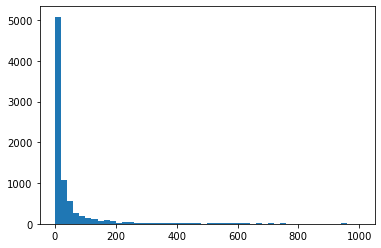

In [38]:
#распределение частот слов
_=plt.hist(list(all_word_freq),range=[0,1000],bins=50)

In [39]:
words = cv.get_feature_names()
len(words)

8249

In [40]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(word_count_vector)

all_normforms_transformed = cv.transform(all_normforms)
all_normforms_tfidf = tfidf_transformer.transform(all_normforms_transformed)

In [41]:
tfidf_transformer.idf_.shape

(8249,)

In [42]:
all_normforms_tfidf.shape

(72389, 8249)

### word2vec


In [43]:
sent_split = [nf.split() for nf in all_normforms]
phrases = Phrases(sent_split, min_count=30)
bigram = Phraser(phrases)
sentences = bigram[sent_split]

In [44]:
w2v = Word2Vec(min_count=20, # Ignores all words with total absolute frequency lower than this
                     window=2,     # The maximum distance between the current and predicted word within a sentence.
                     size=300,     # Dimensionality of the feature vectors.
                     sample=6e-5,  # The threshold for configuring which higher-frequency words are randomly downsampled.
                                   # Highly influencial.
                     alpha=0.03,   # The initial learning rate
                     min_alpha=0.0007, 
                     negative=20) # If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown.
                                  # If set to 0, no negative sampling is used.

In [45]:
w2v.build_vocab(sentences)

In [46]:
w2v.train(sentences, total_examples=w2v.corpus_count, # total_examples - Count of sentences
                epochs=30, report_delay=1)

(6894906, 14403270)

In [47]:
# make the model more memory-efficient
w2v.init_sims(replace=True)

In [48]:
len(w2v.wv.vocab.items())

4399

In [49]:
w2v.wv.most_similar(positive='КОДЕКС')

[('ЭТИКА', 0.6193612217903137),
 ('СЕМЕЙНЫЙ', 0.5697823166847229),
 ('МЕСЯЧНЫЙ', 0.5465676784515381),
 ('2006', 0.5121858716011047),
 ('ЗК', 0.4922666549682617),
 ('ЗЕМЕЛЬНО-КОДЕКС', 0.48882943391799927),
 ('ОБ-ОБРАЗОВАНИЕ', 0.42815130949020386),
 ('ИЗЫСКАТЕЛЬНЫЙ', 0.42647624015808105),
 ('ТМ-Т1', 0.42126545310020447),
 ('РАССРОЧКА', 0.4184477627277374)]

In [50]:
index2word_set = set(w2v.wv.index2word)

# for sentences
def avg_feature_vector(sentence, model, num_features, index2word_set):
    words = sentence.split()
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [51]:
def sentence_similarity(sent1, sent2):
    s1_afv = avg_feature_vector(sent1, model=w2v, num_features=300, index2word_set=index2word_set)
    s2_afv = avg_feature_vector(sent2, model=w2v, num_features=300, index2word_set=index2word_set)
    sim = 1 - spatial.distance.cosine(s1_afv, s2_afv)
    return sim

In [105]:
sentence_similarity('ПОСТАНОВЛЕНИЕ ПРАВИТЕЛЬСТВО РЕСПУБЛИКА МОРДОВИЯ 16-02-2008 7',
                    'ПОСТАНОВЛЕНИЕ ПРАВИТЕЛЬСТВО РМ-16-02-2008 Г 7')

0.8052007555961609

In [106]:
sentence_similarity('ПОСТАНОВЛЕНИЕ ПРАВИТЕЛЬСТВО РЕСПУБЛИКА МОРДОВИЯ 16-02-2008 7',
                    'ПОСТАНОВЛЕНИЕ МЕРА СОЦИАЛЬНЫЙ ПОДДЕРЖКА РАБОТНИК МУНИЦИПАЛЬНЫЙ УЧРЕЖДЕНИЕ УДМУРТИЯ')

0.5062575936317444

In [107]:
sentence_similarity('ПОСТАНОВЛЕНИЕ ПРАВИТЕЛЬСТВО РЕСПУБЛИКА МОРДОВИЯ 16-02-2008 7',
                    'ДЕЙСТВИЕ ТАРИФ ПАССАЖИР-ПЕРЕВОЗКА ВЕЩЬ НАХОДИТЬ ПАССАЖИР ЖИВНОСТЬ')

0.2659355103969574

### final data table

In [108]:
feature_names = cv.get_feature_names()
'постановление' in feature_names

True

In [109]:
idf_df = pd.DataFrame(tfidf_transformer.idf_, index=feature_names, columns=["idf"])
idf_df.tail()

,idf
января,10.580386
января2006,10.580386
ярмарка,9.992599
ярославль,7.807797
ях,10.580386


In [114]:
word_features_table = []
row_names_list = []
Y = []

for it, q_row in tqdm(queries_df.iterrows(), total=queries_df.shape[0]):
    old = normforms_old_df.loc[it]['normal'].split(';')[0]
    new = normforms_new_df.loc[it]['normal'].split(';')[0]
    deleted = [word for word in old.split() if word not in new]
    
    tfidf_row = pd.DataFrame(all_normforms_tfidf[it].T.todense(), index=feature_names, columns=["tfidf"])
    #print(tfidf_row)
    
    for word in old.split():
        if word.lower() in feature_names:
            row_names_list.append(word+'_'+str(it)+'_'+old) # row name
            
            Y.append(1 if word in deleted else 0) # Y
            
            features_row = []
            features_row.append(tfidf_row.loc[word.lower()].tolist()[0]) # tfidf
            features_row.append(idf_df.loc[word.lower()].tolist()[0]) # idf
            features_row.append(sentence_similarity(old, old.replace(word, '').replace('  ', ' '))) # w2v_imp
        
            word_features_table.append(features_row)
    
word_features_df = pd.DataFrame(word_features_table, index=row_names_list,
                                columns=['tfidf', 'idf', 'w2v_imp'])
print(word_features_df.shape)
word_features_df.head()

100%|████████████████████████████████████████████████████████████████████████████▊| 4410/4418 [00:25<00:00, 175.07it/s]


KeyError: 4410